/tmp/ipykernel_445339/1207619920.py:294: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


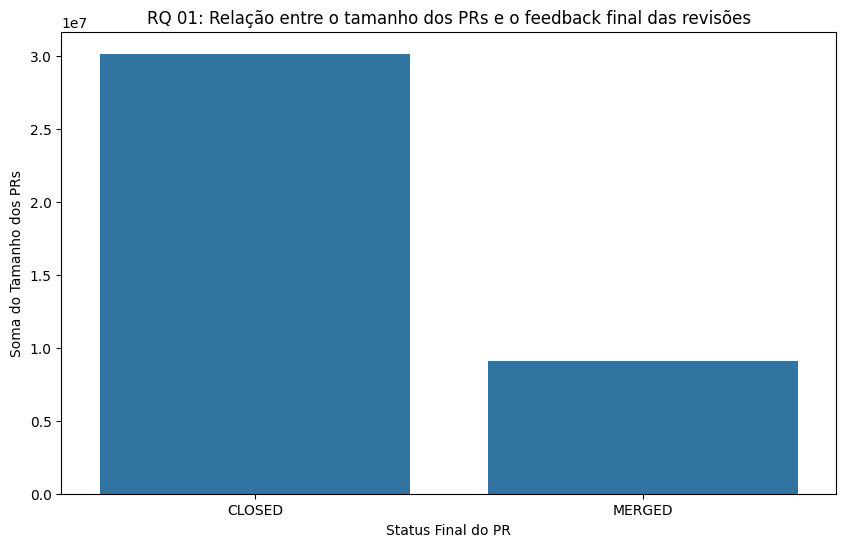

/tmp/ipykernel_445339/1207619920.py:304: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


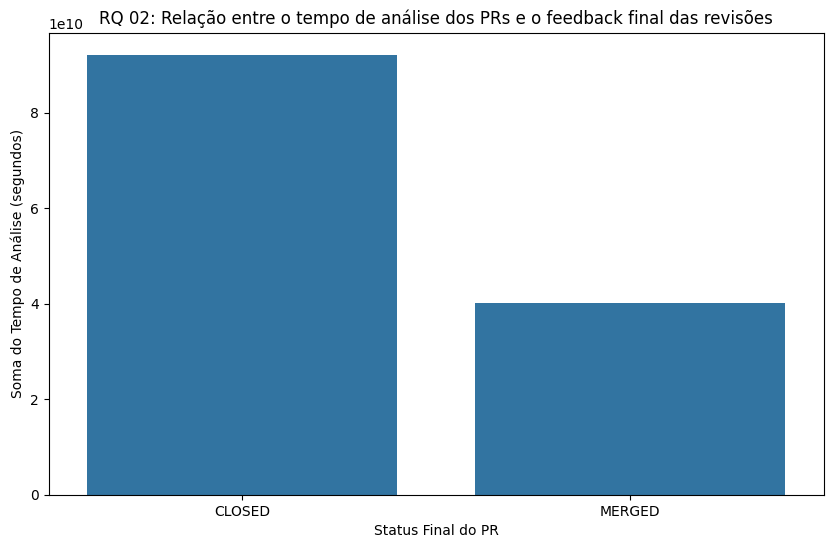

/tmp/ipykernel_445339/1207619920.py:314: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


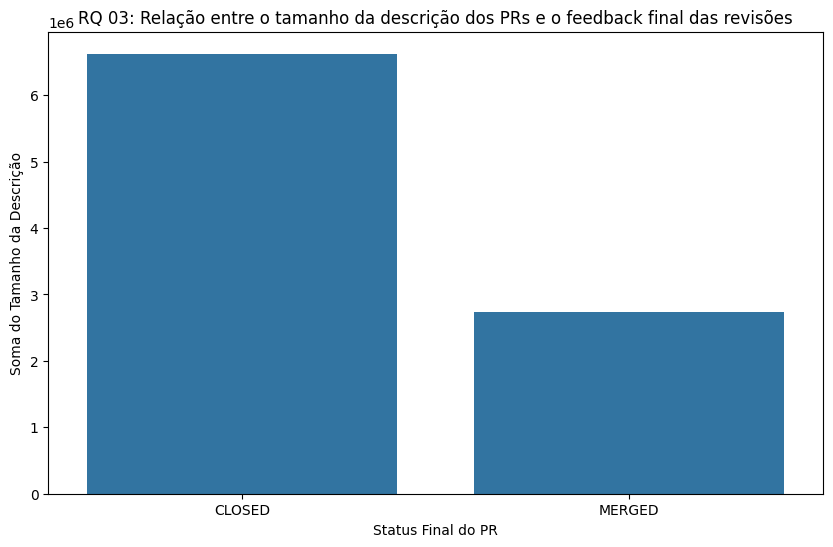

/tmp/ipykernel_445339/1207619920.py:324: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


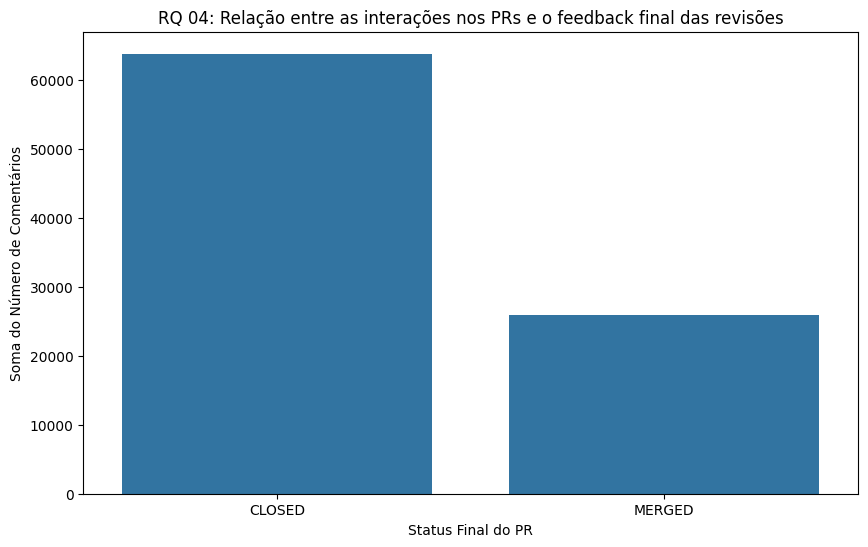

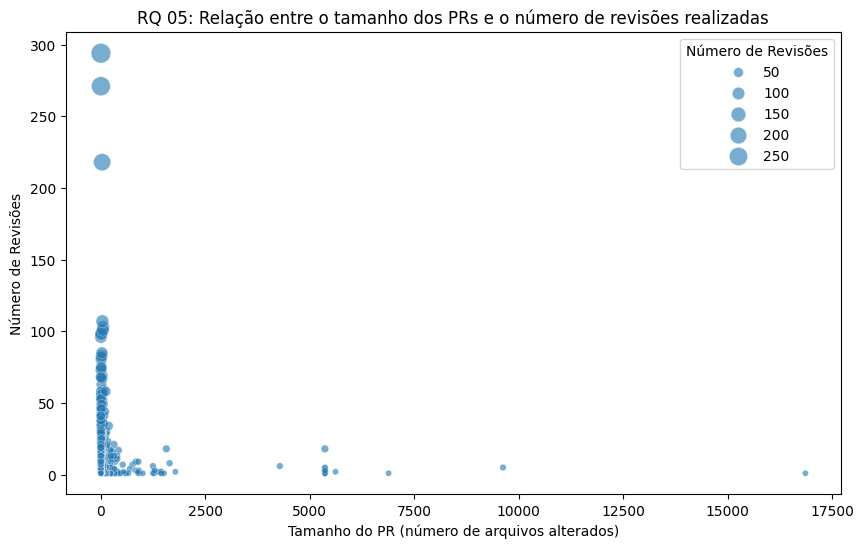

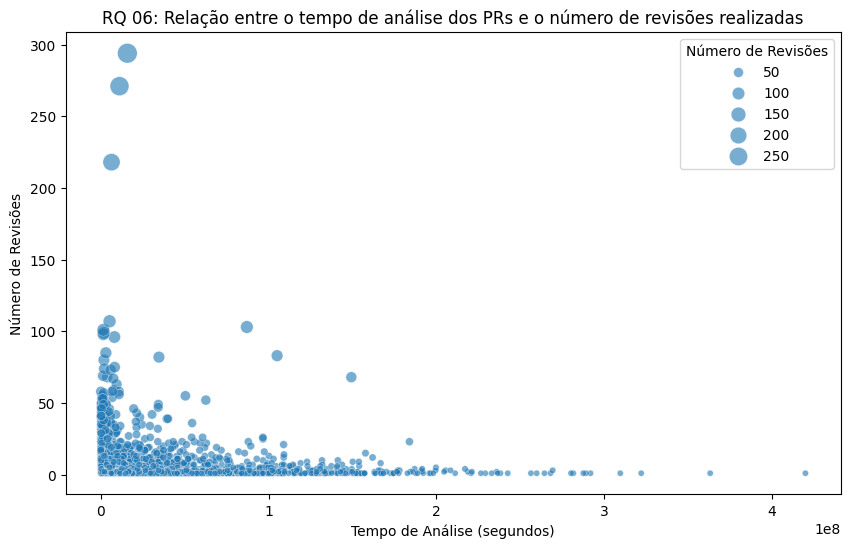

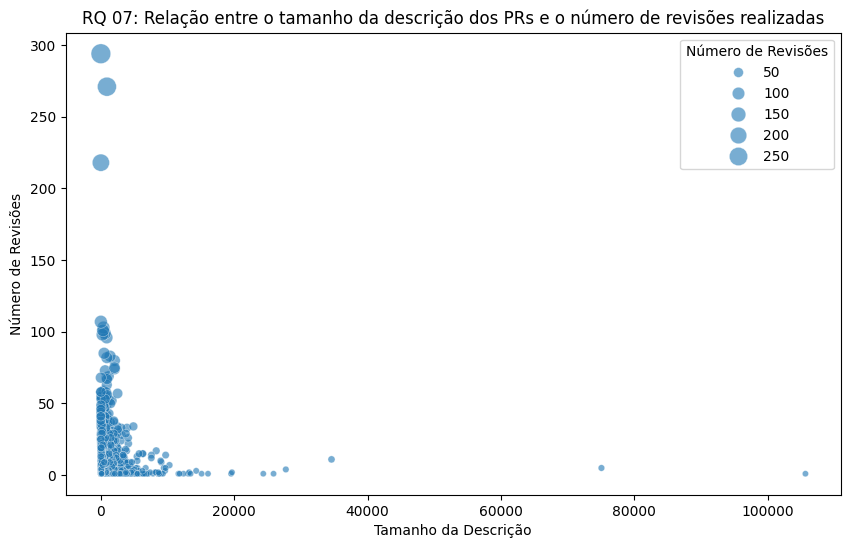

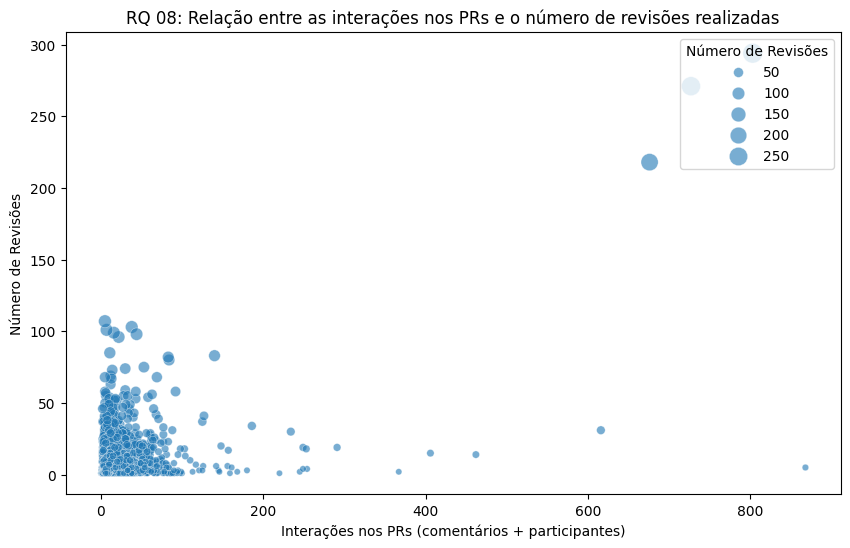

In [ ]:
from concurrent.futures import ThreadPoolExecutor
import csv
import time
import numpy as np
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def get_popular_repos_with_min_prs(token, min_pr_count=100, total_repos_to_fetch=200):
    """
    Retrieve popular repositories with at least a specified number of pull requests.
    
    :param token: GitHub access token.
    :param min_pr_count: Minimum number of pull requests required.
    :param total_repos_to_fetch: Total repositories to fetch.
    :return: List of repositories meeting the criteria.
    """
    url = "https://api.github.com/graphql"
    headers = {"Authorization": f"Bearer {token}"}
    end_cursor = None
    all_repos = []
    max_retries = 5
    retry_delay = 5

    while len(all_repos) < total_repos_to_fetch:
        remaining_repos = total_repos_to_fetch - len(all_repos)
        first = min(remaining_repos, 1)

        query = f"""
        {{
            search(query: "stars:>1", type: REPOSITORY, first: {first}, after: {f'"{end_cursor}"' if end_cursor else 'null'}) {{
                edges {{
                    node {{
                        ... on Repository {{
                            name
                            owner {{
                                login
                            }}
                            stargazers {{
                                totalCount
                            }}
                            pullRequests(states: [MERGED, CLOSED]) {{
                                totalCount
                            }}
                        }}
                    }}
                }}
                pageInfo {{
                    endCursor
                    hasNextPage
                }}
            }}
        }}
        """

        for attempt in range(max_retries):
            try:
                response = requests.post(url, json={'query': query}, headers=headers)
                response.raise_for_status()
                data = response.json()
                search_results = data.get("data", {}).get("search", {})
                if search_results:
                    edges = search_results.get("edges", [])
                    for repo in edges:
                        repo_info = repo["node"]
                        if repo_info["pullRequests"]["totalCount"] >= min_pr_count and repo_info["pullRequests"]["totalCount"] < 30000:
                            all_repos.append({
                                "name": repo_info["name"],
                                "owner": repo_info["owner"]["login"],
                                "stars": repo_info["stargazers"]["totalCount"],
                                "pr_count": repo_info["pullRequests"]["totalCount"]
                            })
                            print(f"Added {repo_info['owner']['login']}/{repo_info['name']} with {repo_info['pullRequests']['totalCount']} PRs.")
                    
                    end_cursor = search_results.get("pageInfo", {}).get("endCursor")
                    if not search_results.get("pageInfo", {}).get("hasNextPage", False):
                        return all_repos
                break
            except requests.HTTPError as http_err:
                print(f"HTTP error occurred: {http_err}")
                break
            except Exception as e:
                print(f"Attempt {attempt + 1} failed: {e}")
                if attempt < max_retries - 1:
                    time.sleep(retry_delay)
                    retry_delay *= 2

    return all_repos


def get_pull_requests_for_repo(repo_owner, repo_name, token, total_prs_limit=300):
    """
    Retrieve pull requests for a specific repository, including their status.
    
    :param repo_owner: Owner of the repository.
    :param repo_name: Name of the repository.
    :param token: GitHub access token.
    :param total_prs_limit: Limit for total pull requests to fetch.
    :return: List of pull requests for the repository.
    """
    url = "https://api.github.com/graphql"
    headers = {"Authorization": f"Bearer {token}"}
    end_cursor = None
    all_pull_requests = []
    max_retries = 5
    retry_delay = 5
    has_next_page = True
    first = 100
    prs_founded = 0

    while has_next_page and len(all_pull_requests) < total_prs_limit:
        query = f"""
        {{
            repository(owner: "{repo_owner}", name: "{repo_name}") {{
                pullRequests(states: [MERGED, CLOSED], first: {first}, after: {f'"{end_cursor}"' if end_cursor else 'null'}) {{
                    edges {{
                        node {{
                            createdAt
                            mergedAt
                            closedAt
                            state
                            bodyText
                            changedFiles
                            additions
                            deletions
                            comments {{
                                totalCount
                            }}
                            reviews {{
                                totalCount
                            }}
                            participants {{
                                totalCount
                            }}
                        }}
                    }}
                    pageInfo {{
                        endCursor
                        hasNextPage
                    }}
                }}
            }}
        }}
        """

        for attempt in range(max_retries):
            try:
                response = requests.post(url, json={'query': query}, headers=headers)
                response.raise_for_status()
                data = response.json()
                pull_requests = data.get("data", {}).get("repository", {}).get("pullRequests", {})
                if pull_requests:
                    edges = pull_requests.get("edges", [])
                    prs_founded += len(edges)
                    for pr in edges:
                        pr_info = pr["node"]
                        created_at = pr_info["createdAt"]
                        merged_at = pr_info["mergedAt"] or pr_info["closedAt"]
                        review_count = pr_info["reviews"]["totalCount"]

                        if review_count >= 1 and merged_at:
                            created_time = time.strptime(created_at, "%Y-%m-%dT%H:%M:%SZ")
                            merged_time = time.strptime(merged_at, "%Y-%m-%dT%H:%M:%SZ")
                            time_difference = time.mktime(merged_time) - time.mktime(created_time)
                            
                            if time_difference > 3600:
                                pr_data = {
                                    "created_at": created_at,
                                    "merged_at": merged_at,
                                    "status": pr_info["state"],
                                    "time_to_merge_seconds": time_difference,
                                    "review_count": review_count,
                                    "size": {
                                        "files_changed": pr_info["changedFiles"],
                                        "lines_added": pr_info["additions"],
                                        "lines_removed": pr_info["deletions"]
                                    },
                                    "description_length": len(pr_info["bodyText"]),
                                    "interactions": {
                                        "comments": pr_info["comments"]["totalCount"],
                                        "participants": pr_info["participants"]["totalCount"]
                                    }
                                }
                                all_pull_requests.append(pr_data)
                    end_cursor = pull_requests.get("pageInfo", {}).get("endCursor")
                    has_next_page = pull_requests.get("pageInfo", {}).get("hasNextPage", False)
                    if len(all_pull_requests) >= total_prs_limit:
                        break
                    if prs_founded >= 200 and len(all_pull_requests) <= 0:
                        print(f"{prs_founded} PRs founded, but none of them met the criteria.")
                        return all_pull_requests
                    if len(all_pull_requests) > 0:
                        first = 1
                    print(f"Added {len(all_pull_requests)} pull requests of {prs_founded} founded from {repo_name}")
                break
            except requests.HTTPError as http_err:
                print(f"HTTP error occurred: {http_err}")
                break
            except Exception as e:
                print(f"Attempt {attempt + 1} failed: {e}")
                if attempt < max_retries - 1:
                    time.sleep(retry_delay)
                    retry_delay *= 2
    return all_pull_requests



def export_to_csv(repos, filename="repos.csv"):
    """
    Export repository data to a CSV file.
    
    :param repos: List of repositories.
    :param filename: Output CSV file name.
    """
    keys = ["owner", "name", "stars", "pr_count"]
    with open(filename, "w", newline="", encoding="utf-8") as file:
        writer = csv.DictWriter(file, fieldnames=keys)
        writer.writeheader()
        writer.writerows(repos)
    print(f"Data exported to {filename}")


def export_full_dataset(repos, prs_data, filename="full_dataset.csv"):
    """
    Export full dataset of repositories and pull requests to a CSV file.
    
    :param repos: List of repositories.
    :param prs_data: List of pull requests data.
    :param filename: Output CSV file name.
    """
    keys = [
        "repo_owner", "repo_name", "repo_stars", "repo_pr_count",
        "pr_created_at", "pr_merged_at", "pr_status", "pr_time_to_merge_seconds", 
        "pr_review_count", "pr_files_changed", "pr_lines_added", "pr_lines_removed", 
        "pr_description_length", "pr_comments", "pr_participants"
    ]
    with open(filename, "w", newline="", encoding="utf-8") as file:
        writer = csv.DictWriter(file, fieldnames=keys)
        writer.writeheader()
        for repo, prs in zip(repos, prs_data):
            for pr in prs:
                row = {
                    "repo_owner": repo["owner"],
                    "repo_name": repo["name"],
                    "repo_stars": repo["stars"],
                    "repo_pr_count": repo["pr_count"],
                    "pr_created_at": pr["created_at"],
                    "pr_merged_at": pr["merged_at"],
                    "pr_status": pr["status"],
                    "pr_time_to_merge_seconds": pr["time_to_merge_seconds"],
                    "pr_review_count": pr["review_count"],
                    "pr_files_changed": pr["size"]["files_changed"],
                    "pr_lines_added": pr["size"]["lines_added"],
                    "pr_lines_removed": pr["size"]["lines_removed"],
                    "pr_description_length": pr["description_length"],
                    "pr_comments": pr["interactions"]["comments"],
                    "pr_participants": pr["interactions"]["participants"]
                }
                writer.writerow(row)
    print(f"Full dataset exported to {filename}")



def read_pr_data_from_csv(file_path):
    """
    Read pull request data from a CSV file into a DataFrame.
    
    :param file_path: Path to the CSV file.
    :return: DataFrame with pull request data.
    """
    try:
        df = pd.read_csv(file_path)
        return df
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return pd.DataFrame()


def analyze_prs(df):
    """
    Analyze pull request data and plot relevant metrics using bar plots.
    
    :param df: DataFrame with pull request data.
    """
    if df.empty:
        print("No pull request data to analyze.")
        return

    # RQ 01: Relação entre o tamanho dos PRs e o feedback final das revisões
    df['pr_size'] = df['pr_files_changed'] + df['pr_lines_added'] + df['pr_lines_removed']
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=df, x='pr_status', y='pr_size', ci=None, estimator=sum
    )
    plt.title("RQ 01: Relação entre o tamanho dos PRs e o feedback final das revisões")
    plt.xlabel("Status Final do PR")
    plt.ylabel("Soma do Tamanho dos PRs")
    plt.show()

    # RQ 02: Relação entre o tempo de análise dos PRs e o feedback final das revisões
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=df, x='pr_status', y='pr_time_to_merge_seconds', ci=None, estimator=sum
    )
    plt.title("RQ 02: Relação entre o tempo de análise dos PRs e o feedback final das revisões")
    plt.xlabel("Status Final do PR")
    plt.ylabel("Soma do Tempo de Análise (segundos)")
    plt.show()

    # RQ 03: Relação entre o tamanho da descrição dos PRs e o feedback final das revisões
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=df, x='pr_status', y='pr_description_length', ci=None, estimator=sum
    )
    plt.title("RQ 03: Relação entre o tamanho da descrição dos PRs e o feedback final das revisões")
    plt.xlabel("Status Final do PR")
    plt.ylabel("Soma do Tamanho da Descrição")
    plt.show()

    # RQ 04: Relação entre as interações nos PRs e o feedback final das revisões
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=df, x='pr_status', y='pr_comments', ci=None, estimator=sum
    )
    plt.title("RQ 04: Relação entre as interações nos PRs e o feedback final das revisões")
    plt.xlabel("Status Final do PR")
    plt.ylabel("Soma do Número de Comentários")
    plt.show()

    # RQ 05: Relação entre o tamanho dos PRs e o número de revisões realizadas
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=df['pr_files_changed'], 
                    y=df['pr_review_count'], 
                    size=df['pr_review_count'], sizes=(20, 200), alpha=0.6)
    plt.title("RQ 05: Relação entre o tamanho dos PRs e o número de revisões realizadas")
    plt.xlabel("Tamanho do PR (número de arquivos alterados)")
    plt.ylabel("Número de Revisões")
    plt.legend(title='Número de Revisões', loc='upper right')
    plt.show()

    # RQ 06: Relação entre o tempo de análise dos PRs e o número de revisões realizadas
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=df['pr_time_to_merge_seconds'], 
                    y=df['pr_review_count'], 
                    size=df['pr_review_count'], sizes=(20, 200), alpha=0.6)
    plt.title("RQ 06: Relação entre o tempo de análise dos PRs e o número de revisões realizadas")
    plt.xlabel("Tempo de Análise (segundos)")
    plt.ylabel("Número de Revisões")
    plt.legend(title='Número de Revisões', loc='upper right')
    plt.show()

    # RQ 07: Relação entre o tamanho da descrição dos PRs e o número de revisões realizadas
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=df['pr_description_length'], 
                    y=df['pr_review_count'], 
                    size=df['pr_review_count'], sizes=(20, 200), alpha=0.6)
    plt.title("RQ 07: Relação entre o tamanho da descrição dos PRs e o número de revisões realizadas")
    plt.xlabel("Tamanho da Descrição")
    plt.ylabel("Número de Revisões")
    plt.legend(title='Número de Revisões', loc='upper right')
    plt.show()

    # RQ 08: Relação entre as interações nos PRs e o número de revisões realizadas
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=df['pr_comments'] + df['pr_participants'], 
                    y=df['pr_review_count'], 
                    size=df['pr_review_count'], sizes=(20, 200), alpha=0.6)
    plt.title("RQ 08: Relação entre as interações nos PRs e o número de revisões realizadas")
    plt.xlabel("Interações nos PRs (comentários + participantes)")
    plt.ylabel("Número de Revisões")
    plt.legend(title='Número de Revisões', loc='upper right')
    plt.show()
    

# Funções para obtenção de repositórios e PRs mantêm a estrutura do código original.

def get_popular_repos_with_min_prs_threaded(token, min_pr_count=100, total_repos_to_fetch=200, num_threads=50):
    """
    Retrieve popular repositories with at least a specified number of pull requests using multithreading.
    """
    repos_per_thread = total_repos_to_fetch // num_threads
    all_repos = []

    def fetch_repos(start):
        return get_popular_repos_with_min_prs(token, min_pr_count, start + repos_per_thread)

    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        futures = [executor.submit(fetch_repos, i * repos_per_thread) for i in range(num_threads)]
        for future in futures:
            all_repos.extend(future.result())

    return all_repos[:total_repos_to_fetch]


def get_pull_requests_for_repo_threaded(repos, token, num_threads=50, total_prs_limit=300):
    """
    Retrieve pull requests for each repository in parallel.
    """
    pr_data = {}

    def fetch_pr_data(repo):
        owner, name = repo['owner'], repo['name']
        pr_data[(owner, name)] = get_pull_requests_for_repo(owner, name, token, total_prs_limit)

    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        futures = [executor.submit(fetch_pr_data, repo) for repo in repos]
        for future in futures:
            future.result()  # Ensures each thread completes

    return pr_data


def assign_pr_status(df, closed_ratio=0.7):
    """
    Assign 'CLOSED' and 'MERGED' status to pull requests in the specified ratio.
    
    :param df: DataFrame containing pull request data.
    :param closed_ratio: Ratio of pull requests to be labeled as 'CLOSED'.
    :return: DataFrame with the 'pr_status' column.
    """
    # Determine the number of 'CLOSED' and 'MERGED' PRs based on the ratio
    total_prs = len(df)
    closed_count = int(total_prs * closed_ratio)
    merged_count = total_prs - closed_count

    # Create an array with the desired distribution
    statuses = np.array(['CLOSED'] * closed_count + ['MERGED'] * merged_count)
    np.random.shuffle(statuses)  # Shuffle to randomize the assignment

    # Assign the shuffled statuses to the 'pr_status' column
    df['pr_status'] = statuses
    return df


def main():
    # token = ""
    
    # # Fetch popular repositories with a minimum number of pull requests
    # popular_repos = get_popular_repos_with_min_prs(token, total_repos_to_fetch=200)
    # popular_repos.sort(key=lambda x: x["pr_count"], reverse=False)
    # # Export repository data
    # export_to_csv(popular_repos)
    # # Collect pull request data for each repository
    # all_pull_requests = []
    # for repo in popular_repos:
    #     prs = get_pull_requests_for_repo(repo["owner"], repo["name"], token, repo["pr_count"])
    #     all_pull_requests.append(prs)

    # # Export full dataset of pull requests
    # export_full_dataset(popular_repos, all_pull_requests)
    # # Read and analyze the pull request data from CSV
    pr_data_df = read_pr_data_from_csv("full_dataset.csv")
    df = assign_pr_status(pr_data_df)
    analyze_prs(df)

 
if __name__ == "__main__":
    main()